<a href="https://colab.research.google.com/github/Pial-Khan/NER/blob/main/Bi_LSTM_CRF_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Named Entity Recognition
In Natural Language Processing (NLP) an Entity Recognition is one of the common problem. The entity is referred to as the part of the text that is interested in. In NLP, NER is a method of extracting the relevant information from a large corpus and classifying those entities into predefined categories such as location, organization, name and so on. 


#### Importing Libraries

In [ ]:
!pip install tensorflow==1.13.1
!pip install keras==2.2.4

In [ ]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git
!pip install sklearn-crfsuite
!pip install seqeval

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-j4h7_tdh
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-j4h7_tdh
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp36-none-any.whl size=101066 sha256=068e7c986257b57f17d6da44009d1230a3914cc4f5950e009a03b149171eb621
  Stored in directory: /tmp/pip-ephem-wheel-cache-kiqhh4g0/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


In [ ]:
import pandas as pd
import numpy as np

from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import LSTM, Dense, TimeDistributed, Embedding, Bidirectional
from keras.models import Model, Input
from keras_contrib.layers import CRF
#from tf2CRF import CRF
from keras.callbacks import ModelCheckpoint

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.metrics import f1_score
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
from keras.preprocessing.text import text_to_word_sequence
import pickle

In [ ]:
#Reading the csv file
df = pd.read_csv('clean_ner_all_campaign_data.csv', encoding = "ISO-8859-1")

In [ ]:
#Display first 10 rows
df.head(10)

,sentence_no,data,Word,position,Tag
0,1,à¦à¦°à¦¶à¦¾à¦¦à¦à§ à¦¨à¦¿à§à§ à¦à¦£à¦¤à¦...,à¦à¦°à¦¶à¦¾à¦¦à¦à§,1,B-PER
1,1,à¦à¦°à¦¶à¦¾à¦¦à¦à§ à¦¨à¦¿à§à§ à¦à¦£à¦¤à¦...,à¦¨à¦¿à§à§,2,O
2,1,à¦à¦°à¦¶à¦¾à¦¦à¦à§ à¦¨à¦¿à§à§ à¦à¦£à¦¤à¦...,à¦à¦£à¦¤à¦¨à§à¦¤à§à¦°,3,O
3,1,à¦à¦°à¦¶à¦¾à¦¦à¦à§ à¦¨à¦¿à§à§ à¦à¦£à¦¤à¦...,à¦¹à¦¤à§à¦¯à¦¾,4,O
4,1,à¦à¦°à¦¶à¦¾à¦¦à¦à§ à¦¨à¦¿à§à§ à¦à¦£à¦¤à¦...,à¦à¦°à§à¦à§,5,O
5,1,à¦à¦°à¦¶à¦¾à¦¦à¦à§ à¦¨à¦¿à§à§ à¦à¦£à¦¤à¦...,à¦¶à§à¦,6,B-PER
6,1,à¦à¦°à¦¶à¦¾à¦¦à¦à§ à¦¨à¦¿à§à§ à¦à¦£à¦¤à¦...,à¦¹à¦¾à¦¸à¦¿à¦¨à¦¾,7,I-PER
7,1,à¦à¦°à¦¶à¦¾à¦¦à¦à§ à¦¨à¦¿à§à§ à¦à¦£à¦¤à¦...,-,8,O
8,1,à¦à¦°à¦¶à¦¾à¦¦à¦à§ à¦¨à¦¿à§à§ à¦à¦£à¦¤à¦...,à¦®à¦¿à¦°à§à¦à¦¾,9,B-PER
9,1,à¦à¦°à¦¶à¦¾à¦¦à¦à§ à¦¨à¦¿à§à§ à¦à¦£à¦¤à¦...,à¦«à¦à¦°à§à¦²,10,I-PER


In [ ]:
df.describe()

,sentence_no,position
count,165714.000000,165714.000000
mean,7256.496464,10.439697
std,4413.564852,11.036701
min,1.000000,1.000000
25%,3229.000000,4.000000
50%,7763.000000,8.000000
75%,11345.000000,13.000000
max,14716.000000,236.000000


#### Observations : 
* There are total 47959 sentences in the dataset.
* Number unique words in the dataset are 35178.
* Total 17 lables (Tags).

In [ ]:
#Displaying the unique Tags
df['Tag'].unique()

array(['B-PER', 'O', 'I-PER', 'B-ORG', 'B-Date', 'I-Date', 'B-EVE',
       'I-EVE', 'B-LOC', 'I-LOC', 'I-ORG'], dtype=object)

In [ ]:
#Checking null values, if any.
df.isnull().sum()

sentence_no    0
data           0
Word           2
position       0
Tag            0
dtype: int64

There are lots of missing values in 'Sentence #' attribute. So we will use pandas fillna technique and use 'ffill' method which propagates last valid observation forward to next.

In [ ]:
df = df.fillna(method = 'ffill')

In [ ]:
# This is a class te get sentence. The each sentence will be list of tuples with its tag and pos.
class sentence(object):
    def __init__(self, df):
        self.n_sent = 1
        self.df = df
        self.empty = False
        agg = lambda s : [(w, t) for w, t in zip(s['Word'].values.tolist(),
                                                       s['Tag'].values.tolist())]
        self.grouped = self.df.groupby("sentence_no").apply(agg)
        self.sentences = [s for s in self.grouped]
        
    def get_text(self):
        try:
            s = self.grouped['Sentence: {}'.format(self.n_sent)]
            self.n_sent +=1
            return s
        except:
            return None

In [ ]:
#Displaying one full sentence
getter = sentence(df)
sentences = [" ".join([s[0] for s in sent]) for sent in getter.sentences]
sentences[0]

'à¦\x8fà¦°à¦¶à¦¾à¦¦à¦\x95à§\x87 à¦¨à¦¿à§\x9fà§\x87 à¦\x97à¦£à¦¤à¦¨à§\x8dà¦¤à§\x8dà¦° à¦¹à¦¤à§\x8dà¦¯à¦¾ à¦\x95à¦°à§\x87à¦\x9bà§\x87 à¦¶à§\x87à¦\x96 à¦¹à¦¾à¦¸à¦¿à¦¨à¦¾ - à¦®à¦¿à¦°à§\x8dà¦\x9cà¦¾ à¦«à¦\x96à¦°à§\x81à¦²'

In [ ]:
#sentence with its pos and tag.
sent = getter.get_text()
print(sent)

None


Getting all the sentences in the dataset.

In [ ]:
sentences = getter.sentences

#### Defining the parameters for LSTM network

In [ ]:
# Number of data points passed in each iteration
batch_size = 64 
# Passes through entire dataset
epochs = 8
# Maximum length of review
max_len = 75 
# Dimension of embedding vector
embedding = 40 

#### Preprocessing Data
We will process our text data before feeding to the network.
* Here word_to_index dictionary used to convert word into index value and tag_to_index is for the labels. So overall we represent each word as integer.

In [ ]:
#Getting unique words and labels from data
words = list(df['Word'].unique())
tags = list(df['Tag'].unique())
# Dictionary word:index pair
# word is key and its value is corresponding index
word_to_index = {w : i + 2 for i, w in enumerate(words)}
word_to_index["UNK"] = 1
word_to_index["PAD"] = 0

# Dictionary lable:index pair
# label is key and value is index.
tag_to_index = {t : i + 1 for i, t in enumerate(tags)}
tag_to_index["PAD"] = 0

idx2word = {i: w for w, i in word_to_index.items()}
idx2tag = {i: w for w, i in tag_to_index.items()}

In [ ]:
#print("The word India is identified by the index: {}".format(word_to_index["India"]))
#print("The label B-org for the organization is identified by the index: {}".format(tag_to_index["B-org"]))

In [ ]:
# Converting each sentence into list of index from list of tokens
X = [[word_to_index[w[0]] for w in s] for s in sentences]

# Padding each sequence to have same length  of each word
X = pad_sequences(maxlen = max_len, sequences = X, padding = "post", value = word_to_index["PAD"])

In [ ]:
# Convert label to index
y = [[tag_to_index[w[1]] for w in s] for s in sentences]

# padding
y = pad_sequences(maxlen = max_len, sequences = y, padding = "post", value = tag_to_index["PAD"])

In [ ]:
num_tag = df['Tag'].nunique()
# One hot encoded labels
y = [to_categorical(i, num_classes = num_tag + 1) for i in y]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15)

In [ ]:
print("Size of training input data : ", X_train.shape)
print("Size of training output data : ", np.array(y_train).shape)
print("Size of testing input data : ", X_test.shape)
print("Size of testing output data : ", np.array(y_test).shape)

Size of training input data :  (10182, 75)
Size of training output data :  (10182, 75, 12)
Size of testing input data :  (1797, 75)
Size of testing output data :  (1797, 75, 12)


In [ ]:
# Let's check the first sentence before and after processing.
print('*****Before Processing first sentence : *****\n', ' '.join([w[0] for w in sentences[0]]))
print('*****After Processing first sentence : *****\n ', X[0])

*****Before Processing first sentence : *****
 à¦à¦°à¦¶à¦¾à¦¦à¦à§ à¦¨à¦¿à§à§ à¦à¦£à¦¤à¦¨à§à¦¤à§à¦° à¦¹à¦¤à§à¦¯à¦¾ à¦à¦°à§à¦à§ à¦¶à§à¦ à¦¹à¦¾à¦¸à¦¿à¦¨à¦¾ - à¦®à¦¿à¦°à§à¦à¦¾ à¦«à¦à¦°à§à¦²
*****After Processing first sentence : *****
  [ 2  3  4  5  6  7  8  9 10 11  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0]


In [ ]:
# First label before and after processing.
print('*****Before Processing first sentence : *****\n', ' '.join([w[1] for w in sentences[0]]))
print('*****After Processing first sentence : *****\n ', y[0])

*****Before Processing first sentence : *****
 B-PER O O O O B-PER I-PER O B-PER I-PER
*****After Processing first sentence : *****
  [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 

#### Bidirectional LSTM-CRF Network

In [ ]:
num_tags = df['Tag'].nunique()
# Model architecture
input = Input(shape = (max_len,))
model = Embedding(input_dim = len(words) + 2, output_dim = embedding, input_length = max_len, mask_zero = True)(input)
model = Bidirectional(LSTM(units = 50, return_sequences=True, recurrent_dropout=0.1))(model)
model = TimeDistributed(Dense(50, activation="relu"))(model)
crf = CRF(num_tags+1)  # CRF layer
out = crf(model)  # output

model = Model(input, out)
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 75)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 75, 40)            831800    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 75, 100)           36400     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 75, 50)            5050      
_________________________________________________________________
crf_1 (CRF)                  (None, 75, 12)            780       
Total params: 874,030
Trainable params: 874,030
Non-trainable params: 0
_______________

Making Checkpoint each epoch to check and save the best model performance till last and also avoiding further validation loss drop due to overfitting.

In [ ]:
checkpointer = ModelCheckpoint(filepath = 'model.h5',
                       verbose = 0,
                       mode = 'auto',
                       save_best_only = True,
                       monitor='val_loss')

In [ ]:
history = model.fit(X_train, np.array(y_train), batch_size=batch_size, epochs=epochs,
                    validation_split=0.1, callbacks=[checkpointer])

Instructions for updating:
Use tf.cast instead.
Train on 9163 samples, validate on 1019 samples
Epoch 1/8
9163/9163 [==============================] - 31s 3ms/step - loss: 16.7267 - crf_viterbi_accuracy: 0.8181 - val_loss: 16.4346 - val_crf_viterbi_accuracy: 0.8541
Epoch 2/8
9163/9163 [==============================] - 30s 3ms/step - loss: 16.3062 - crf_viterbi_accuracy: 0.8805 - val_loss: 16.3272 - val_crf_viterbi_accuracy: 0.8936
Epoch 3/8
9163/9163 [==============================] - 29s 3ms/step - loss: 16.2112 - crf_viterbi_accuracy: 0.9103 - val_loss: 16.2795 - val_crf_viterbi_accuracy: 0.9060
Epoch 4/8
9163/9163 [==============================] - 29s 3ms/step - loss: 16.1470 - crf_viterbi_accuracy: 0.9326 - val_loss: 16.2777 - val_crf_viterbi_accuracy: 0.8966
Epoch 5/8
9163/9163 [==============================] - 29s 3ms/step - loss: 16.1065 - crf_viterbi_accuracy: 0.9447 - val_loss: 16.2353 - val_crf_viterbi_accuracy: 0.9114
Epoch 6/8
9163/9163 [==============================] -

In [ ]:
history.history.keys()

dict_keys(['val_loss', 'val_crf_viterbi_accuracy', 'loss', 'crf_viterbi_accuracy'])

Visualizing the performance of model.

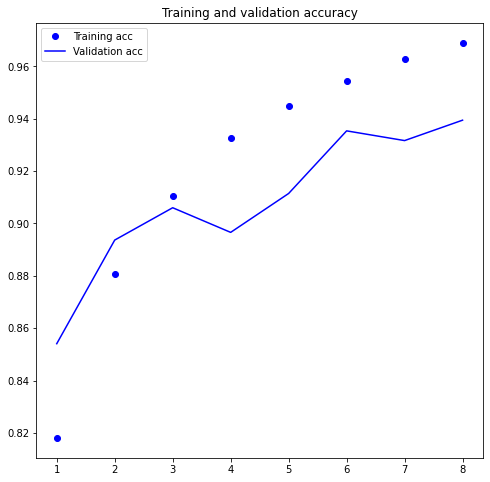

In [ ]:
acc = history.history['crf_viterbi_accuracy']
val_acc = history.history['val_crf_viterbi_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize = (8, 8))
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

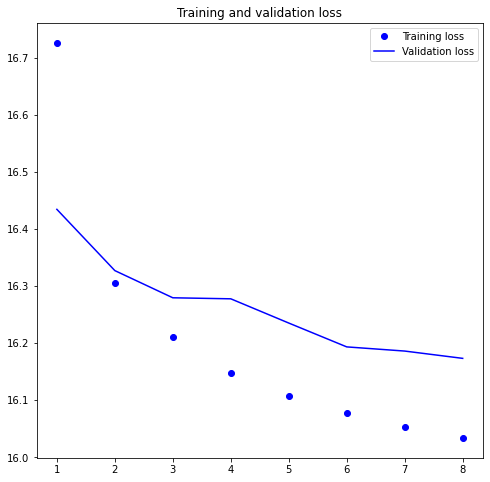

In [ ]:
plt.figure(figsize = (8, 8))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

#### Evaluating the model on test set

In [ ]:
# Evaluation
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_test_true = np.argmax(y_test, -1)

In [ ]:
# Convert the index to tag
y_pred = [[idx2tag[i] for i in row] for row in y_pred]
y_test_true = [[idx2tag[i] for i in row] for row in y_test_true] 

In [ ]:
print("F1-score is : {:.1%}".format(f1_score(y_test_true, y_pred)))

F1-score is : 82.8%


In [ ]:
report = flat_classification_report(y_pred=y_pred, y_true=y_test_true)
print(report)

              precision    recall  f1-score   support

      B-Date       0.89      0.87      0.88       200
       B-EVE       0.00      0.00      0.00        52
       B-LOC       0.79      0.70      0.74       617
       B-ORG       0.49      0.69      0.57       421
       B-PER       0.90      0.84      0.87       873
      I-Date       0.88      0.84      0.86       102
       I-EVE       0.00      0.00      0.00        83
       I-LOC       0.47      0.44      0.46       252
       I-ORG       0.48      0.69      0.57       383
       I-PER       0.93      0.89      0.91       843
           O       0.97      0.97      0.97     21055
         PAD       1.00      1.00      1.00    109894

    accuracy                           0.99    134775
   macro avg       0.65      0.66      0.65    134775
weighted avg       0.99      0.99      0.99    134775



In [ ]:
# At every execution model picks some random test sample from test set.
i = np.random.randint(0,X_test.shape[0]) # choose a random number between 0 and len(X_te)b
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
true = np.argmax(y_test[i], -1)

print("Sample number {} of {} (Test Set)".format(i, X_test.shape[0]))
# Visualization
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_test[i], true, p[0]):
    if w != 0:
        print("{:15}: {:5} {}".format(words[w-2], idx2tag[t], idx2tag[pred]))

Sample number 1704 of 1797 (Test Set)
Word           ||True ||Pred
à¦à¦¤à¦¿à¦°à¦¿à¦à§à¦¤: O     O
à¦ªà§à¦²à¦¿à¦¶: O     O
à¦¸à§à¦ªà¦¾à¦°: O     O
à¦®à§         : B-PER B-PER
.              : I-PER I-PER
à¦°à¦à¦      : I-PER I-PER
à¦à¦¦à§à¦¦à¦¿à¦¨: I-PER I-PER
à¦à¦°à¦      : O     O
à¦¬à¦²à§à¦¨   : O     O
,              : O     O
à¦à¦         : O     O
à¦à¦¾à¦¤à§à¦°à§à¦à§: O     O
à¦¤à§à¦²à§   : O     O
à¦¨à¦¿à§à§   : O     O
à¦à¦à§à¦à¦¾à¦¤: O     O
à¦¸à§à¦¥à¦¾à¦¨à§: O     O
à¦à¦à¦à§   : O     O
à¦°à§à¦à§   : O     O
à§¨à§¦         : O     O
à¦¦à¦¿à¦¨      : O     O
à¦§à¦°à§      : O     O
à¦§à¦°à§à¦·à¦£: O     O
à¦à¦°à¦à§   : O     O
à¦à§à¦¹à¦¶à¦¿à¦à§à¦·à¦: O     O
à¦®à¦¾à¦¸à§à¦¦: B-PER B-PER
à¦°à¦¾à¦¨à¦¾   : I-PER I-PER


#### Save the result

In [ ]:
with open('word_to_index.pickle', 'wb') as f:
    pickle.dump(word_to_index, f)

with open('tag_to_index.pickle', 'wb') as f:
    pickle.dump(tag_to_index, f)